# Digit Recognizer 数字识别器
## 数据集描述
+ 数据文件训练.csv和测试.csv包含从零到九的手绘数字的灰度图像。

+ 每张图像高 28 像素，宽 28 像素，总共 784 像素。每个像素都有一个与之关联的像素值，指示该像素的明暗度，数字越大表示越暗。此像素值是介于 0 和 255 之间的整数（包括 0 和 255）。

+ 训练数据集 （train.csv） 有 785 列。第一列称为“标签”，是用户绘制的数字。其余列包含关联图像的像素值。

+ 训练集中的每个像素列都有一个类似于 pixelx 的名称，其中 x 是介于 0 和 783 之间的整数（包括 0 和 783）。要在图像上定位此像素，假设我们将 x 分解为 x = i * 28 + j，其中 i 和 j 是介于 0 和 27 之间的整数，包括 0 和 27。然后 pixelx 位于 28 x 28 矩阵的第 i 行和第 j 列上（索引为零）。

In [129]:
import torch
from torch.utils import data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F

## 读取数据

In [130]:
train_data=pd.read_csv("data/digit-recognizer/train.csv")
train_data


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 抽样数据
+ **随机抽样**

In [164]:
#训练集10个一组，4100组
train_deal=(torch.tensor(np.array(train_data.iloc[:41000,0])),torch.tensor(np.array(train_data.iloc[:41000,1:])/255))
print(train_deal[1].shape,train_deal[0].shape)
train=data.DataLoader(data.TensorDataset(*train_deal),10,shuffle=False)
#测试集10个一组，100组
experimental=(torch.tensor(np.array(train_data.iloc[41000:42000,0])),torch.tensor(np.array(train_data.iloc[41000:42000,1:])/255))
print(experimental[1].shape)
experimental=data.DataLoader(data.TensorDataset(*experimental),10,shuffle=False)

next(iter(train))

torch.Size([41000, 784]) torch.Size([41000])
torch.Size([1000, 784])


[tensor([1, 0, 1, 4, 0, 0, 7, 3, 5, 3]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)]

+ 显示部分数据

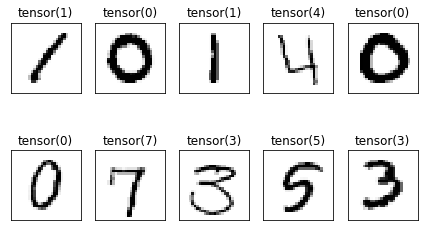

In [132]:
fig, ax = plt.subplots(nrows=2,ncols=5,sharex=True,sharey=True)
ax = ax.flatten()
for i in range(10):
    img = next(iter(train))[1][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title( next(iter(train))[0][i])
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## 构建模型
+ **定义模型**

In [133]:
net=nn.Sequential(nn.Flatten().to(torch.float64),nn.Linear(784,10).to(torch.float64))
def init_weight(m):
    if type(m)==nn.Linear:
        nn.init.normal_(m.weight,std=0.01)
net.apply(init_weight)

#损失函数
loss=nn.CrossEntropyLoss(reduction="none")

#梯度下降
lr=0.1 #学习率
trainer=torch.optim.SGD(net.parameters(),lr=lr)

+ **训练**

In [134]:
#计算准确率
def rigth_rate(y_guess,y):
    if len(y_guess)>1 and len(y)>1:
        y_guess=y_guess.argmax(axis=1)
        cmp =y_guess.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def training_model(net, train_iter, loss, updater):
    
    if isinstance(net,torch.nn.Module):
        net.train()
    
    # 计算训练损失总和、训练准确度总和、样本数
    addtion=[0.0]*3
    for y,x in train_iter:
        y=F.one_hot(torch.tensor(y).to(torch.int64),num_classes=10).to(torch.float64)
        y_guess=net(x)
        l=loss(y_guess,y)
        updater.zero_grad()
        l.mean().backward()
        updater.step()

        addtion[0]+=float(l.sum())
        addtion[1]+=rigth_rate(y_guess,y)
        addtion[2]+=y.numel()
    
    #      训练损失总和/样本数   ; 训练准确度总和/样本数
    return addtion[0]/addtion[2],addtion[1]/addtion[2]

In [139]:
#训练次数
learn=10
train_loss,train_acc=np.zeros(10),np.zeros(10)

for i in range(learn):
    #损失率和准确率
    train_loss[i],train_acc[i]= training_model(net,train,loss,trainer)
    print('loss:',train_loss[i],' acc: ',train_acc[i])

C:\Users\Tom Huang\AppData\Local\Temp\ipykernel_22008\1736035103.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=F.one_hot(torch.tensor(y).to(torch.int64),num_classes=10).to(torch.float64)


loss: 0.024365027124792504  acc:  0.10056585365853658
loss: 0.024292815422068615  acc:  0.1005829268292683
loss: 0.02422410824666395  acc:  0.10058536585365854
loss: 0.02415860186877338  acc:  0.1005780487804878
loss: 0.02409602946155735  acc:  0.10057073170731708
loss: 0.024036155463697095  acc:  0.10058536585365854
loss: 0.023978770971057946  acc:  0.10062926829268293
loss: 0.023923689938748893  acc:  0.10068048780487805
loss: 0.02387074602773593  acc:  0.10062682926829268
loss: 0.023819789968829146  acc:  0.1005609756097561


+ **验证模型**

In [147]:
addtion=[0.0]*2
for y,x in experimental:
    preds =net(x).argmax(axis=1)
    cmp= preds==y
    addtion[0]+=cmp.sum()
    addtion[1]+=y.numel()
rate=addtion[0]/addtion[1]
print('准确率',rate)

准确率 tensor(0.9150)


## 预测
+ **读取数据**

In [180]:
test_data=pd.read_csv("data/digit-recognizer/test.csv",sep=',')
test_data

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [181]:
with open('answer/digit_recognizer.csv','w') as file:
    file.write('ImageId,Label\n')
    for i in range(len(test_data)):
        file.write(str(i+1)+','+str(np.array(net(torch.tensor([np.array(test_data.iloc[i,:])/255])).argmax(axis=1))[0])+'\n')